In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Library untuk menangani class imbalance
from imblearn.over_sampling import SMOTE

# Library untuk hyperparameter tuning (alternatif yang lebih baik)
import keras_tuner as kt

import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur gaya visualisasi
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# 1. MEMUAT DAN MEMPERSIAPKAN DATA

In [5]:
# Muat dataset dari file CSV
df = pd.read_csv('hasil_atr_btc.csv')

# Menghapus kolom yang tidak diperlukan
# df = df.drop(columns=['Unnamed: 0']) # This column does not exist

# Mengubah kolom 'date' menjadi tipe data datetime dan menjadikannya sebagai index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Memeriksa data yang hilang
print("Pemeriksaan nilai yang hilang:")
print(df.isnull().sum())
print("-" * 30)

Pemeriksaan nilai yang hilang:
Close          0
Open           0
Volume         0
Low            0
High           0
EMA200         0
MACD_Line      0
MACD_Line.1    0
Signal_Line    0
Histogram      0
RSI            0
SMA200         0
ATR            0
Type           0
Profit (%)     0
Label          0
dtype: int64
------------------------------


# 2. PREPROCESSING DATA

In [6]:
# Mendefinisikan fitur (X) dan target (y)
features = ['Open', 'High', 'Low', 'Volume', 'ATR']
target = 'Close'

X = df[features]
y = df[[target]] # Menggunakan kurung siku ganda agar tetap menjadi DataFrame

# Normalisasi data ke rentang [0, 1]
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False)

print(f"Jumlah data latih: {X_train.shape[0]}")
print(f"Jumlah data uji: {X_test.shape[0]}")
print("-" * 30)

Jumlah data latih: 1846
Jumlah data uji: 462
------------------------------


# 3. MEMBANGUN MODEL JARINGAN SARAF

In [7]:
model = tf.keras.Sequential([
    # Input layer dengan bentuk sesuai jumlah fitur
    tf.keras.layers.Input(shape=(X_train.shape[1],)),

    # Hidden layer pertama
    tf.keras.layers.Dense(64, activation='relu'),

    # Hidden layer kedua
    tf.keras.layers.Dense(32, activation='relu'),

    # Output layer untuk prediksi regresi (1 neuron, tanpa aktivasi/linear)
    tf.keras.layers.Dense(1, activation='linear')
])

# Mengompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Menampilkan ringkasan arsitektur model
model.summary()
print("-" * 30)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------


# 4. EXPLORATORY DATA ANALYSIS (EDA)

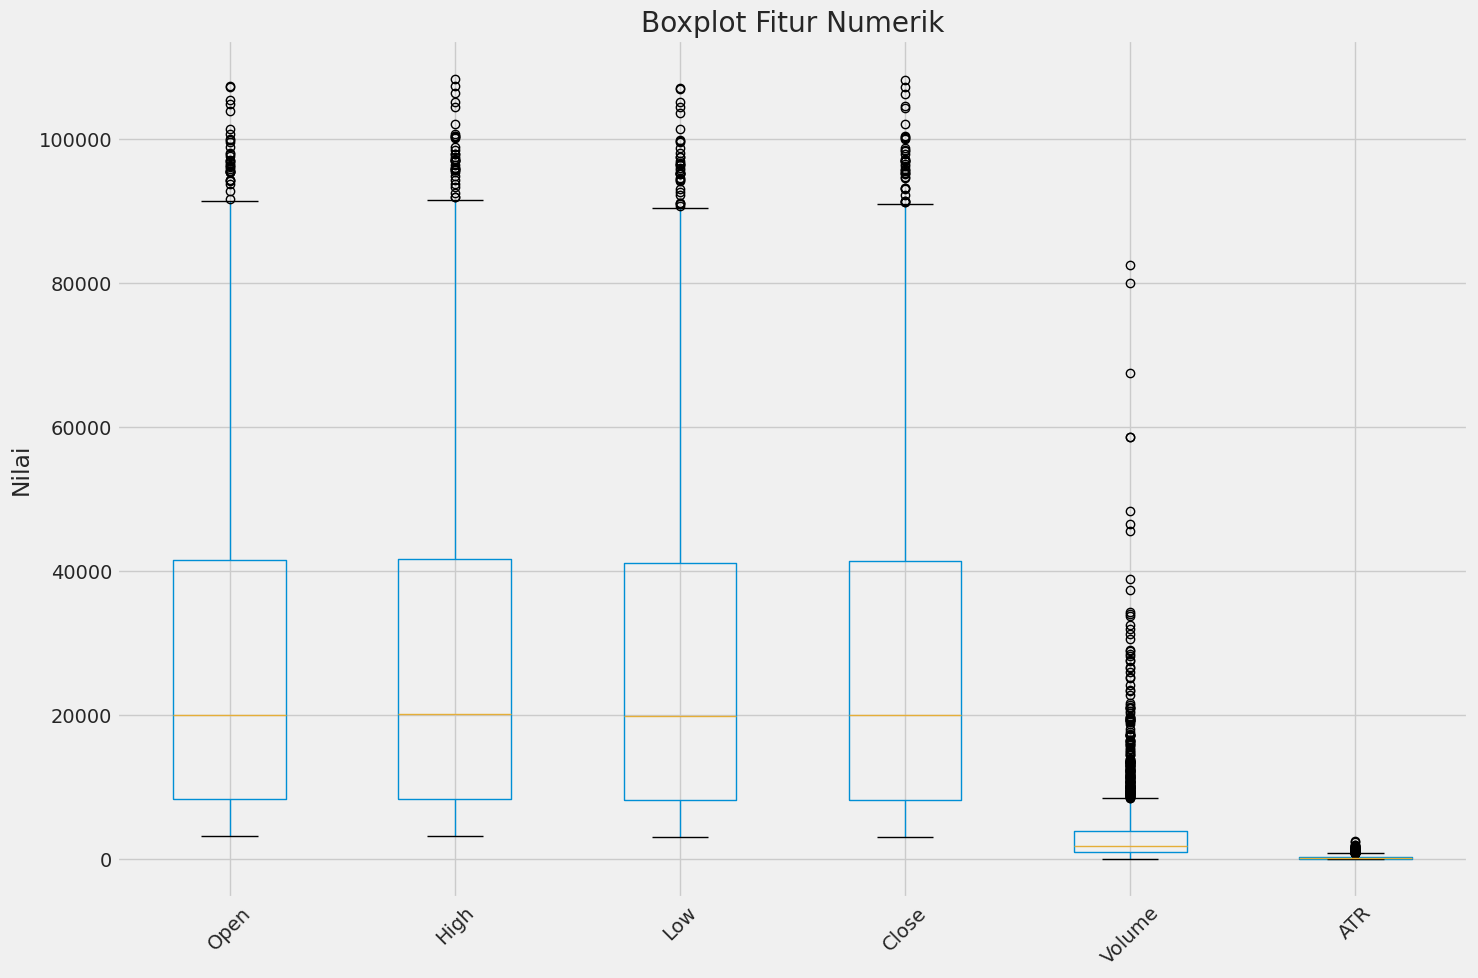

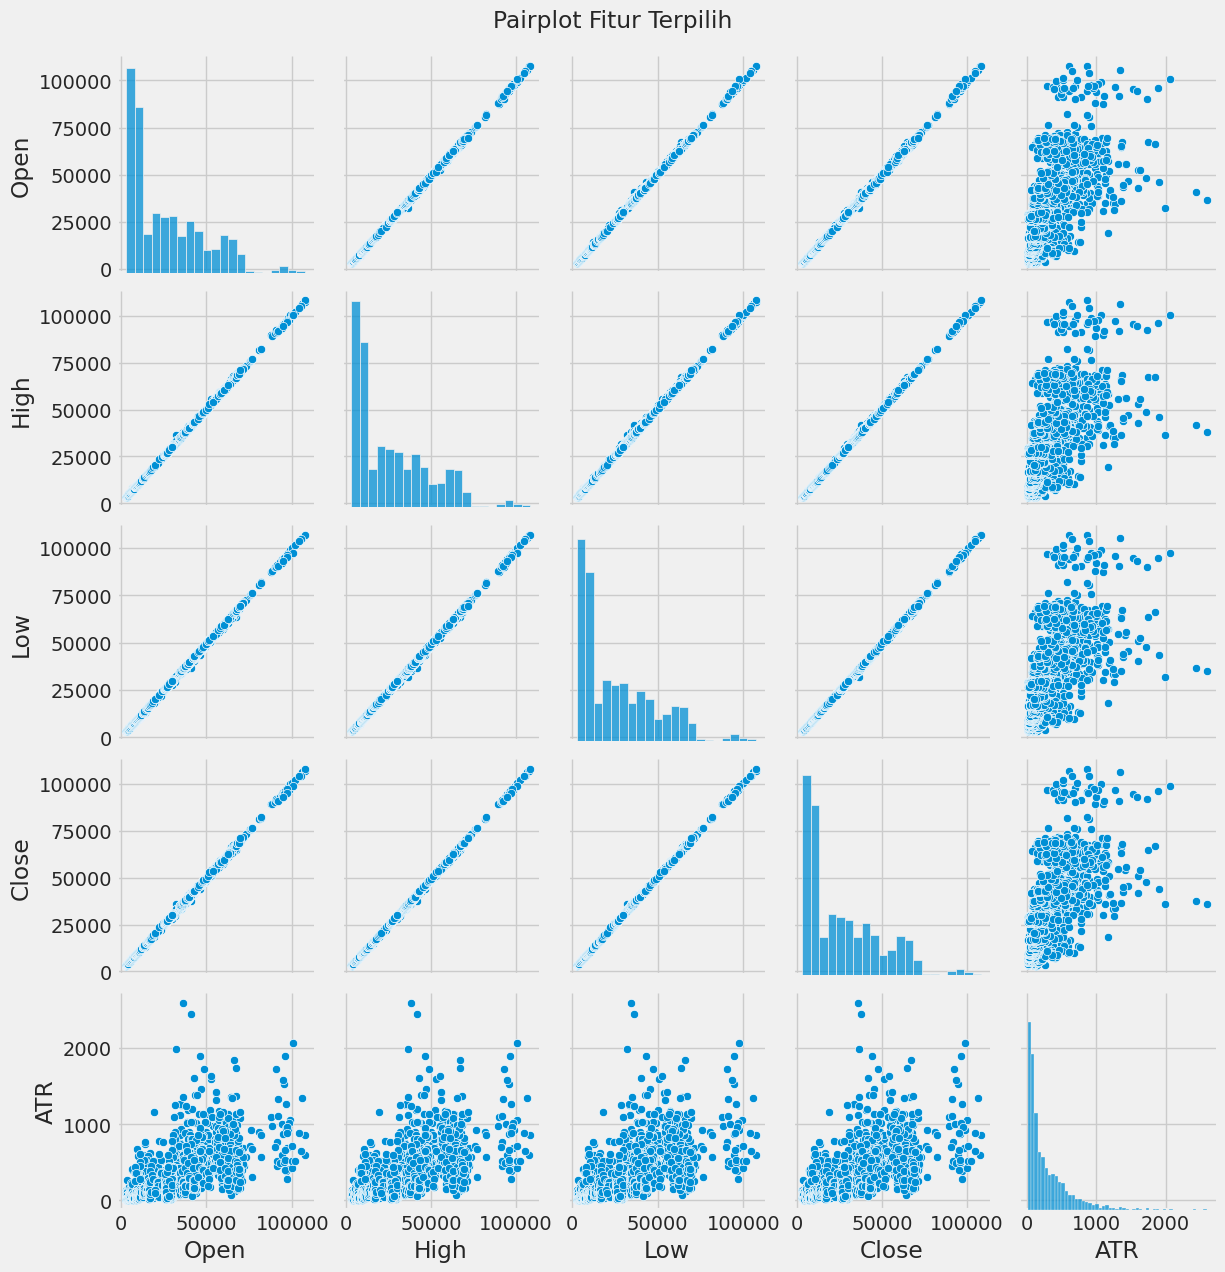

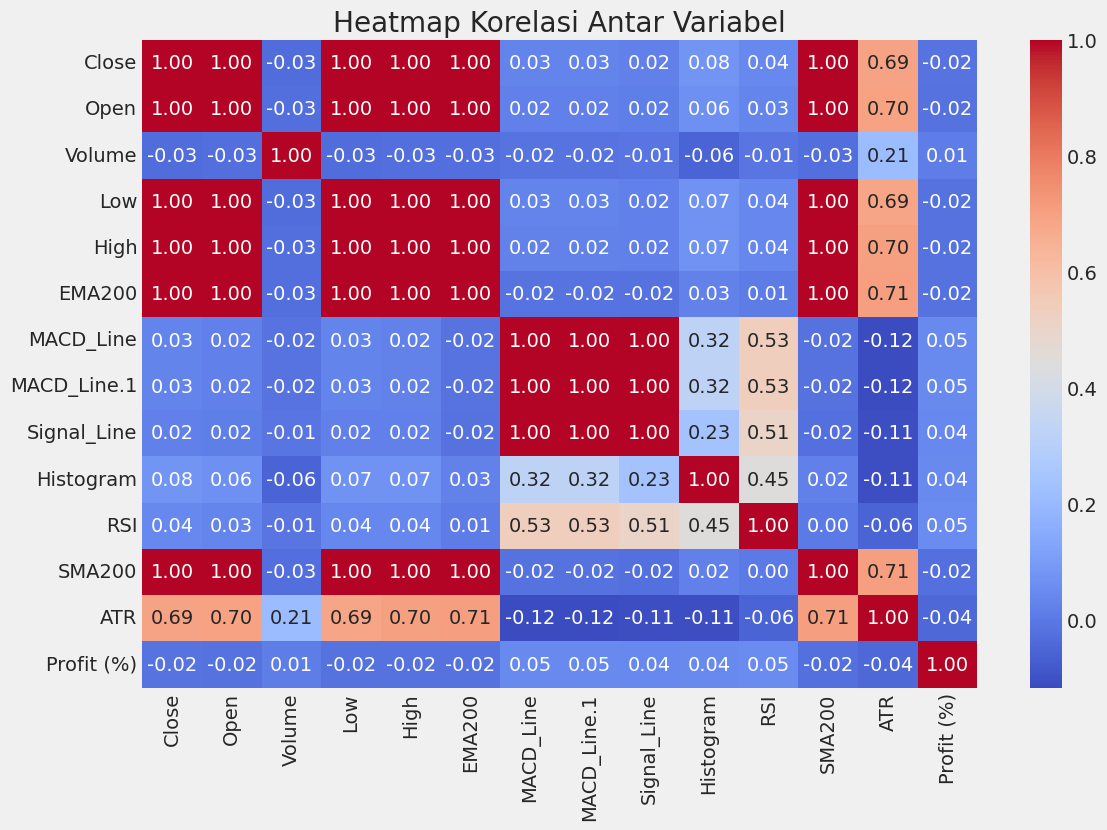

In [8]:
# Visualisasi menggunakan Boxplot untuk melihat distribusi dan outlier
plt.figure(figsize=(15, 10))
df[['Open', 'High', 'Low', 'Close', 'Volume', 'ATR']].boxplot()
plt.title('Boxplot Fitur Numerik')
plt.ylabel('Nilai')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualisasi menggunakan Pairplot untuk melihat hubungan antar fitur numerik
# Mengambil subset fitur untuk Pairplot agar tidak terlalu padat
sns.pairplot(df[['Open', 'High', 'Low', 'Close', 'ATR']])
plt.suptitle('Pairplot Fitur Terpilih', y=1.02)
plt.show()

# Visualisasi menggunakan Heatmap untuk melihat korelasi antar variabel
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Variabel')
plt.show()

# Analisis Data Eksplorasi (EDA)

Analisis Statistik Deskriptif:


,Close,Open,Volume,Low,High,EMA200,MACD_Line,MACD_Line.1,Signal_Line,Histogram,RSI,SMA200,ATR,Profit (%)
count,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000,2308.000000
mean,26714.304285,26712.065550,3535.409284,26542.321114,26877.289965,26583.686400,2.869301,2.869301,2.758764,0.110537,50.968287,26567.877758,269.182223,0.123185
std,21905.853876,21877.336664,5557.733628,21763.188750,22015.385183,21668.661094,194.122219,194.122219,189.134762,17.939780,12.170774,21713.082551,294.326439,2.746227
min,3100.000000,3192.800000,0.000000,3100.000000,3197.360000,3392.827965,-1781.131150,-1781.131150,-1715.805712,-186.400337,16.467412,0.000000,9.683333,-13.830000
25%,8320.527500,8324.915000,968.953268,8269.990000,8409.587500,8436.924276,-37.262393,-37.262393,-37.727303,-2.967403,43.044692,8375.389625,66.265000,-1.010000
50%,20001.750000,20112.230000,1868.717831,19914.000000,20186.340000,20210.521765,3.333317,3.333317,2.588377,0.255315,51.075709,20118.142775,153.431667,-0.380000
75%,41476.827500,41595.455000,3993.906971,41241.560000,41758.935000,41346.301807,50.914380,50.914380,49.912149,3.708826,59.106154,41105.037812,390.766667,0.452500
max,108258.390000,107406.610000,82580.760740,107130.000000,108353.000000,102820.466400,1210.282504,1210.282504,1188.416563,157.747611,93.248120,102664.288100,2593.480000,31.980000



Distribusi Fitur Numerik:


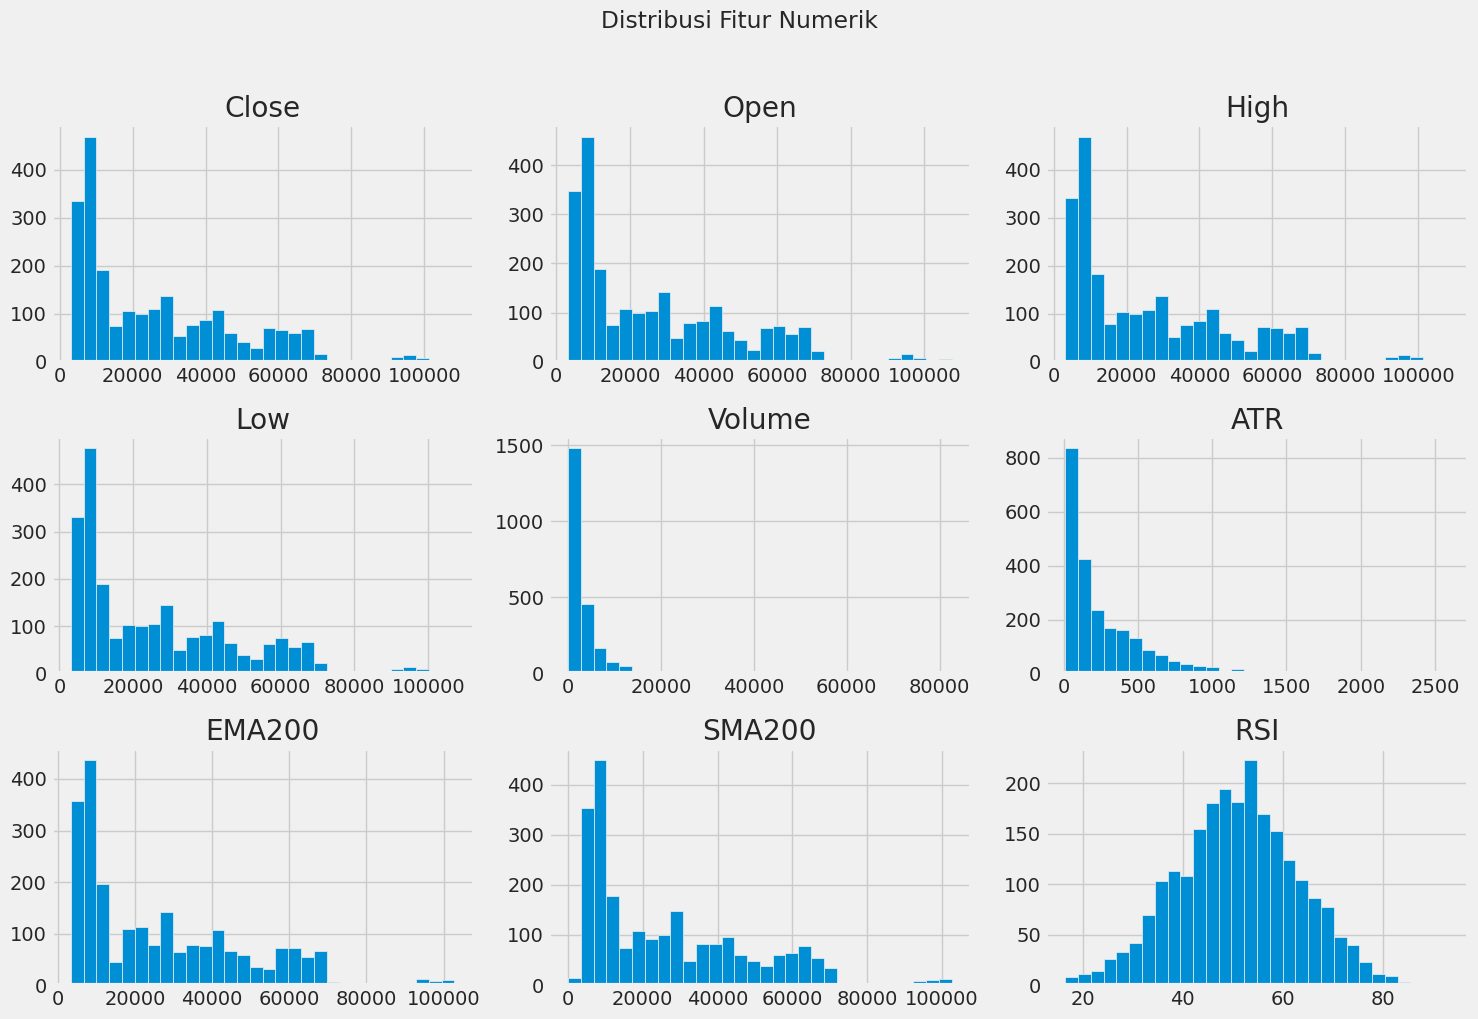

In [9]:
print("Analisis Statistik Deskriptif:")
display(df.describe())

print("\nDistribusi Fitur Numerik:")
numerical_features = ['Close', 'Open', 'High', 'Low', 'Volume', 'ATR', 'EMA200', 'SMA200', 'RSI']
df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribusi Fitur Numerik', y=1.02)
plt.tight_layout()
plt.show()

# Analisis Korelasi


Matriks Korelasi:


,Close,Open,Volume,Low,High,EMA200,MACD_Line,MACD_Line.1,Signal_Line,Histogram,RSI,SMA200,ATR,Profit (%)
Close,1.000000,0.999854,-0.030476,0.999944,0.999926,0.997185,0.028520,0.028520,0.022014,0.076527,0.041881,0.996167,0.693262,-0.017155
Open,0.999854,1.000000,-0.029756,0.999907,0.999937,0.997921,0.021529,0.021529,0.016150,0.062696,0.033472,0.997004,0.695759,-0.018161
Volume,-0.030476,-0.029756,1.000000,-0.033262,-0.027323,-0.027502,-0.016269,-0.016269,-0.011393,-0.055934,-0.012797,-0.026799,0.205847,0.010235
Low,0.999944,0.999907,-0.033262,1.000000,0.999877,0.997396,0.026581,0.026581,0.020466,0.071855,0.038919,0.996408,0.689461,-0.017344
High,0.999926,0.999937,-0.027323,0.999877,1.000000,0.997618,0.024456,0.024456,0.018564,0.068917,0.037516,0.996660,0.699086,-0.018007
EMA200,0.997185,0.997921,-0.027502,0.997396,0.997618,1.000000,-0.016154,-0.016154,-0.019060,0.026146,0.005011,0.999760,0.705397,-0.021510
MACD_Line,0.028520,0.021529,-0.016269,0.026581,0.024456,-0.016154,1.000000,1.000000,0.995956,0.320647,0.533836,-0.020300,-0.117647,0.046832
MACD_Line.1,0.028520,0.021529,-0.016269,0.026581,0.024456,-0.016154,1.000000,1.000000,0.995956,0.320647,0.533836,-0.020300,-0.117647,0.046832
Signal_Line,0.022014,0.016150,-0.011393,0.020466,0.018564,-0.019060,0.995956,0.995956,1.000000,0.234251,0.505268,-0.022731,-0.110329,0.043825
Histogram,0.076527,0.062696,-0.055934,0.071855,0.068917,0.026146,0.320647,0.320647,0.234251,1.000000,0.449601,0.019985,-0.109854,0.044725


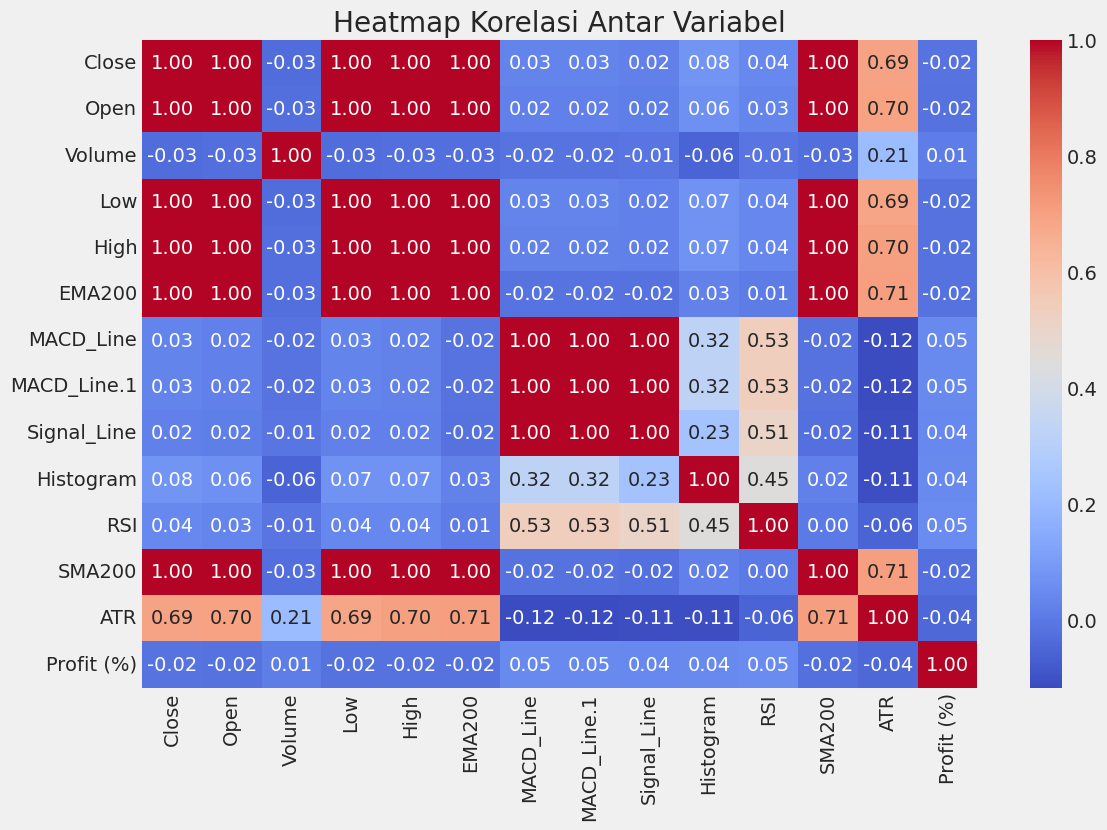

In [10]:
print("\nMatriks Korelasi:")
correlation_matrix = df.corr(numeric_only=True)
display(correlation_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Variabel')
plt.show()

# Analisis Distribusi Label


Distribusi Label:


,count
Label,
Hold,1581
Buy,406
Sell,321


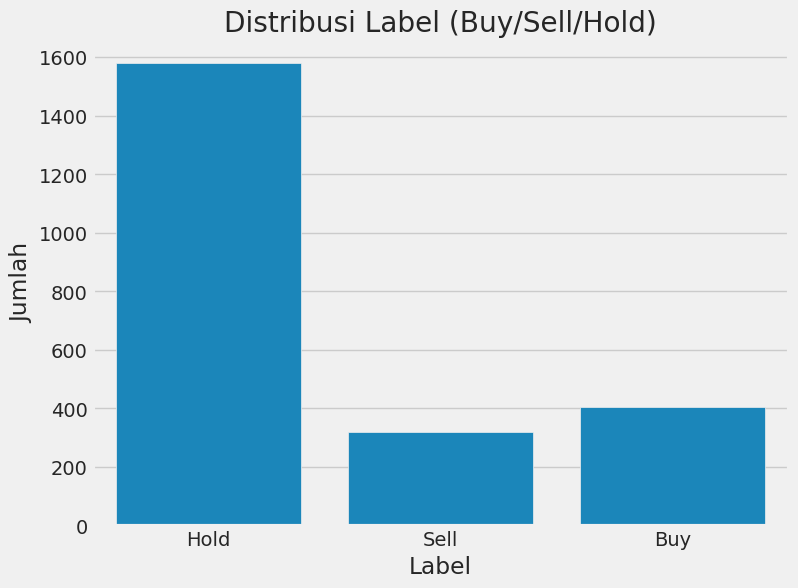

In [11]:
print("\nDistribusi Label:")
display(df['Label'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df)
plt.title('Distribusi Label (Buy/Sell/Hold)')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

# 5. MELATIH MODEL


In [12]:
print("Memulai pelatihan model...")
# Melatih model dan menyimpan riwayat pelatihan
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1 # Menampilkan progress bar
)
print("Pelatihan model selesai.")
print("-" * 30)

Memulai pelatihan model...
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0249 - val_loss: 0.0044
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7046e-04 - val_loss: 8.5707e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9698e-05 - val_loss: 6.0921e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6300e-05 - val_loss: 4.3951e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7000e-05 - val_loss: 3.7978e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1430e-06 - val_loss: 2.8487e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5161e-06 - val_loss: 2.6809e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7474e-06 - val_loss: 2.9714e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0804e-06 - val_loss: 2.7720e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6202e-06 - val_loss: 2.4416e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8

# 6. EVALUASI MODEL


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Membuat prediksi pada data uji
y_pred_scaled = model.predict(X_test)

# Mengembalikan nilai prediksi dan nilai aktual ke skala aslinya
y_pred_actual = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Menghitung metrik evaluasi
mae = mean_absolute_error(y_test_actual.flatten(), y_pred_actual.flatten())
mse = mean_squared_error(y_test_actual.flatten(), y_pred_actual.flatten())
rmse = np.sqrt(mse)

print("Hasil Evaluasi Model pada Data Uji:")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print("-" * 30)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Hasil Evaluasi Model pada Data Uji:
Mean Absolute Error (MAE): $690.76
Root Mean Squared Error (RMSE): $1,356.24
------------------------------


# 7. VISUALISASI HASIL


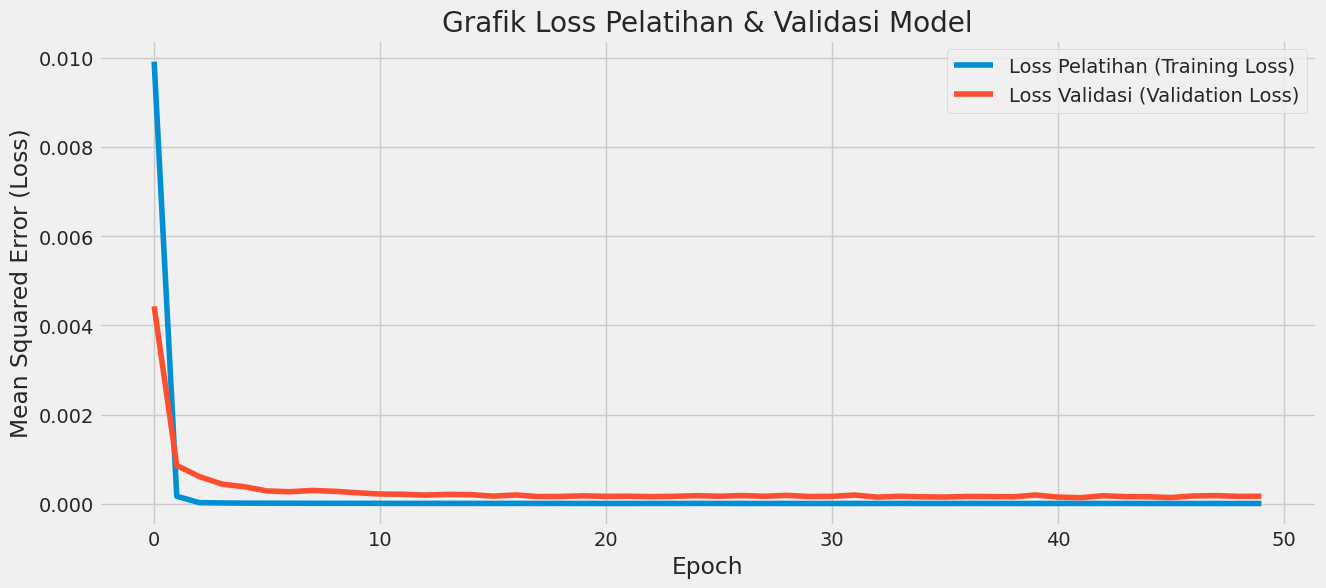

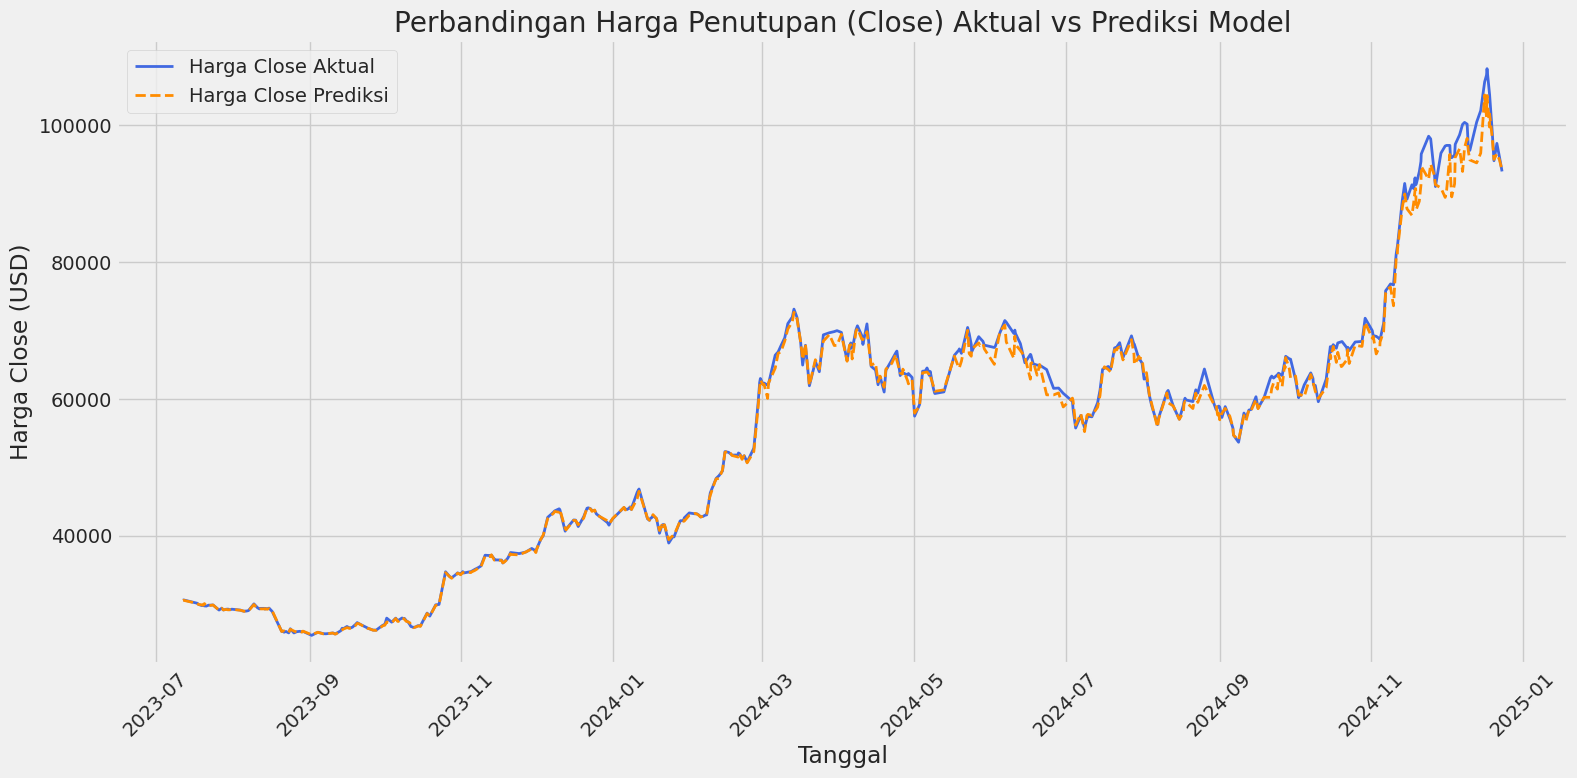

In [14]:
# Visualisasi 1: Grafik Loss Pelatihan vs Validasi
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Loss Pelatihan (Training Loss)')
plt.plot(history.history['val_loss'], label='Loss Validasi (Validation Loss)')
plt.title('Grafik Loss Pelatihan & Validasi Model')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.show()

# Visualisasi 2: Grafik Perbandingan Harga Aktual vs Prediksi
# Membuat DataFrame untuk memudahkan plotting
results_df = pd.DataFrame({
    'Tanggal': df.index[-len(y_test_actual):],
    'Harga Aktual': y_test_actual.flatten(),
    'Harga Prediksi': y_pred_actual.flatten()
})
results_df.set_index('Tanggal', inplace=True)


plt.figure(figsize=(16, 8))
plt.plot(results_df['Harga Aktual'], label='Harga Close Aktual', color='royalblue', linewidth=2)
plt.plot(results_df['Harga Prediksi'], label='Harga Close Prediksi', color='darkorange', linestyle='--', linewidth=2)
plt.title('Perbandingan Harga Penutupan (Close) Aktual vs Prediksi Model')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Siapkan data untuk klasifikasi

### Subtask:
Lakukan Label Encoding pada kolom 'Label' dan definisikan fitur (X_clf) dan target (y_clf) untuk model klasifikasi.


In [15]:
from sklearn.preprocessing import LabelEncoder

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Aplikasikan Label Encoding pada kolom 'Label'
df['Label_encoded'] = label_encoder.fit_transform(df['Label'])

# Definisikan fitur (X_clf) dan target (y_clf) untuk model klasifikasi
X_clf = df.drop(columns=['Label', 'Type', 'Profit (%)', 'Label_encoded']) # Drop the original 'Label' column and others not needed for features
y_clf = df['Label_encoded'] # Use the encoded label as target

print("Label encoding applied and X_clf, y_clf defined.")
print(f"Shape of X_clf: {X_clf.shape}")
print(f"Shape of y_clf: {y_clf.shape}")
print("-" * 30)
display(df[['Label', 'Label_encoded']].head())

Label encoding applied and X_clf, y_clf defined.
Shape of X_clf: (2308, 13)
Shape of y_clf: (2308,)
------------------------------


,Label,Label_encoded
Timestamp,,
2017-08-17 17:00:00,Hold,1
2017-08-18 10:00:00,Hold,1
2017-08-18 14:00:00,Sell,2
2017-08-19 04:00:00,Hold,1
2017-08-20 13:00:00,Hold,1


## Bagi data klasifikasi

### Subtask:
Bagi data fitur dan target klasifikasi menjadi set pelatihan dan pengujian.


In [16]:
# Bagi data fitur dan target klasifikasi menjadi set pelatihan dan pengujian
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Cetak bentuk (shape) dari set pelatihan dan pengujian
print("Shape of X_train_clf:", X_train_clf.shape)
print("Shape of X_test_clf:", X_test_clf.shape)
print("Shape of y_train_clf:", y_train_clf.shape)
print("Shape of y_test_clf:", y_test_clf.shape)

Shape of X_train_clf: (1846, 13)
Shape of X_test_clf: (462, 13)
Shape of y_train_clf: (1846,)
Shape of y_test_clf: (462,)


## Bangun dan latih model klasifikasi awal

### Subtask:
Buat model klasifikasi sederhana (misalnya, neural network atau model lain) dan latih menggunakan data pelatihan awal.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the classification model
clf_model = Sequential([
    # Input layer with shape matching the number of features in X_train_clf
    Dense(128, activation='relu', input_shape=(X_train_clf.shape[1],)),

    # Hidden layer
    Dense(64, activation='relu'),

    # Output layer with 3 neurons (for 3 classes: Buy, Hold, Sell) and softmax activation for multi-class classification
    Dense(3, activation='softmax')
])

# Compile the classification model
clf_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
                  metrics=['accuracy'])

# Train the classification model
print("Memulai pelatihan model klasifikasi...")
history_clf = clf_model.fit(
    X_train_clf,
    y_train_clf,
    epochs=50, # You can adjust the number of epochs
    batch_size=32, # You can adjust the batch size
    validation_data=(X_test_clf, y_test_clf),
    verbose=1 # Menampilkan progress bar
)
print("Pelatihan model klasifikasi selesai.")
print("-" * 30)

# Display the model summary
clf_model.summary()
print("-" * 30)

Memulai pelatihan model klasifikasi...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5342 - loss: 1175.1630 - val_accuracy: 0.4545 - val_loss: 208.5748
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5323 - loss: 166.1213 - val_accuracy: 0.2251 - val_loss: 273.4700
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5102 - loss: 466.9068 - val_accuracy: 0.6840 - val_loss: 241.3587
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5351 - loss: 168.1893 - val_accuracy: 0.6667 - val_loss: 431.8890
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5338 - loss: 357.1472 - val_accuracy: 0.6797 - val_loss: 159.1154
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5370 - loss: 194.4760 - val_accuracy: 0.6861 - val_loss: 156.6542
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5566 - loss: 195.2788 - val_accuracy: 0.5216 - val_loss: 199.7647
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5400 - loss: 234.3865 - val_accuracy

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,731 (120.05 KB)

 Trainable params: 10,243 (40.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,488 (80.04 KB)

------------------------------


## Evaluasi model klasifikasi awal

### Subtask:
Evaluasi performa model klasifikasi awal menggunakan metrik yang sesuai (misalnya, akurasi, presisi, recall, F1-score, classification report).


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score
import numpy as np

# Define the parameter grid for manual search
param_grid_manual = {
    'epochs': [50, 100],
    'batch_size': [32, 64],
    'optimizer': ['adam', 'rmsprop'],
    'units1': [64, 128],
    'units2': [32, 64]
}

best_accuracy = 0
best_params = {}
history_best_model = None # To store history of the best model training

print("Memulai proses Manual Hyperparameter Search...")

# Iterate through all combinations of hyperparameters
for epochs in param_grid_manual['epochs']:
    for batch_size in param_grid_manual['batch_size']:
        for optimizer_name in param_grid_manual['optimizer']:
            for units1 in param_grid_manual['units1']:
                for units2 in param_grid_manual['units2']:

                    print(f"\nTesting params: epochs={epochs}, batch_size={batch_size}, optimizer={optimizer_name}, units1={units1}, units2={units2}")

                    # Build the model with the current parameters
                    model = Sequential([
                        Dense(units1, activation='relu', input_shape=(X_train_clf.shape[1],)),
                        Dense(units2, activation='relu'),
                        Dense(3, activation='softmax')
                    ])

                    # Select optimizer
                    if optimizer_name == 'adam':
                        opt = Adam()
                    elif optimizer_name == 'rmsprop':
                        opt = RMSprop()
                    else:
                        opt = Adam() # Default

                    model.compile(optimizer=opt,
                                  loss='sparse_categorical_crossentropy',
                                  metrics=['accuracy'])

                    # Train the model
                    # Using validation_data for evaluation during training
                    history = model.fit(
                        X_train_clf,
                        y_train_clf,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test_clf, y_test_clf), # Evaluate on test data
                        verbose=0 # Set verbose to 0 to keep output clean during tuning
                    )

                    # Evaluate the model on the test data
                    loss, accuracy = model.evaluate(X_test_clf, y_test_clf, verbose=0)
                    print(f"Accuracy on test data: {accuracy:.4f}")

                    # Check if this is the best model so far
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {
                            'epochs': epochs,
                            'batch_size': batch_size,
                            'optimizer': optimizer_name,
                            'units1': units1,
                            'units2': units2
                        }
                        # Store the best model (optional, might consume memory) or just its history/params
                        # For simplicity, we'll just store the history of the best one found so far
                        history_best_model = history


print("\nProses Manual Hyperparameter Search selesai.")
print("-" * 30)

print("Best Accuracy found: %f using %s" % (best_accuracy, best_params))
print("-" * 30)

# Note: To get the actual best model, you would retrain it using best_params found above.
# For evaluation and prediction, we can use the history of the best model found during the loop
# or retrain a model specifically with best_params.
# Let's define and train the best model explicitly for later use

print("Melatih model final dengan hyperparameter terbaik...")
final_best_clf_model = Sequential([
    Dense(best_params['units1'], activation='relu', input_shape=(X_train_clf.shape[1],)),
    Dense(best_params['units2'], activation='relu'),
    Dense(3, activation='softmax')
])

if best_params['optimizer'] == 'adam':
    opt_final = Adam()
elif best_params['optimizer'] == 'rmsprop':
    opt_final = RMSprop()
else:
    opt_final = Adam()

final_best_clf_model.compile(optimizer=opt_final,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

history_final_best_model = final_best_clf_model.fit(
    X_train_clf,
    y_train_clf,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_test_clf, y_test_clf),
    verbose=1 # Show training progress for the final model
)
print("Pelatihan model final selesai.")
print("-" * 30)

# Evaluate the final best model on test data
print("Evaluation of the Final Best Model on Test Data:")
loss_final, accuracy_final = final_best_clf_model.evaluate(X_test_clf, y_test_clf, verbose=0)
print(f"Overall Accuracy (Final Best Model): {accuracy_final:.4f}")
print("-" * 30)

# Now you can use final_best_clf_model for predictions on new data or further analysis

Memulai proses Manual Hyperparameter Search...

Testing params: epochs=50, batch_size=32, optimizer=adam, units1=64, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.3377

Testing params: epochs=50, batch_size=32, optimizer=adam, units1=64, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6147

Testing params: epochs=50, batch_size=32, optimizer=adam, units1=128, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.3052

Testing params: epochs=50, batch_size=32, optimizer=adam, units1=128, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6818

Testing params: epochs=50, batch_size=32, optimizer=rmsprop, units1=64, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.3961

Testing params: epochs=50, batch_size=32, optimizer=rmsprop, units1=64, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6537

Testing params: epochs=50, batch_size=32, optimizer=rmsprop, units1=128, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6861

Testing params: epochs=50, batch_size=32, optimizer=rmsprop, units1=128, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.2922

Testing params: epochs=50, batch_size=64, optimizer=adam, units1=64, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.3203

Testing params: epochs=50, batch_size=64, optimizer=adam, units1=64, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.5758

Testing params: epochs=50, batch_size=64, optimizer=adam, units1=128, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6429

Testing params: epochs=50, batch_size=64, optimizer=adam, units1=128, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6277

Testing params: epochs=50, batch_size=64, optimizer=rmsprop, units1=64, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6840

Testing params: epochs=50, batch_size=64, optimizer=rmsprop, units1=64, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.4610

Testing params: epochs=50, batch_size=64, optimizer=rmsprop, units1=128, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.1991

Testing params: epochs=50, batch_size=64, optimizer=rmsprop, units1=128, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.3896

Testing params: epochs=100, batch_size=32, optimizer=adam, units1=64, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6667

Testing params: epochs=100, batch_size=32, optimizer=adam, units1=64, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6861

Testing params: epochs=100, batch_size=32, optimizer=adam, units1=128, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6688

Testing params: epochs=100, batch_size=32, optimizer=adam, units1=128, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.5909

Testing params: epochs=100, batch_size=32, optimizer=rmsprop, units1=64, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6861

Testing params: epochs=100, batch_size=32, optimizer=rmsprop, units1=64, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6861

Testing params: epochs=100, batch_size=32, optimizer=rmsprop, units1=128, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6840

Testing params: epochs=100, batch_size=32, optimizer=rmsprop, units1=128, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6861

Testing params: epochs=100, batch_size=64, optimizer=adam, units1=64, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.6429

Testing params: epochs=100, batch_size=64, optimizer=adam, units1=64, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.5281

Testing params: epochs=100, batch_size=64, optimizer=adam, units1=128, units2=32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test data: 0.3810

Testing params: epochs=100, batch_size=64, optimizer=adam, units1=128, units2=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
X_train_clf = scaler_X.transform(X_train_clf)
X_test_clf = scaler_X.transform(X_test_clf)

## Summary:

### Data Analysis Key Findings

* Data berhasil dimuat dan diproses, termasuk konversi kolom 'Timestamp' ke tipe datetime dan menjadikannya index.
* Tidak ditemukan nilai yang hilang dalam dataset.
* Analisis Statistik Deskriptif menunjukkan distribusi nilai untuk berbagai fitur, termasuk harga (Open, High, Low, Close), Volume, dan indikator teknikal.
* Boxplot membantu memvisualisasikan distribusi dan potensi outlier pada fitur numerik.
* Pairplot memberikan gambaran visual tentang hubungan antar fitur terpilih.
* Heatmap korelasi menunjukkan hubungan yang kuat antara harga (Open, High, Low, Close, EMA200, SMA200) dan korelasi yang lebih rendah dengan Volume, ATR, dan indikator lainnya.
* Distribusi label 'Buy', 'Sell', dan 'Hold' menunjukkan bahwa kelas 'Hold' memiliki jumlah data terbanyak.
* Label Encoding berhasil diterapkan pada kolom 'Label', membuat kolom 'Label_encoded' untuk digunakan dalam model klasifikasi.
* Dataset berhasil dibagi menjadi set pelatihan dan pengujian untuk model klasifikasi, dengan stratifikasi untuk menjaga proporsi label.

### Model Training and Evaluation

* Model regresi awal (untuk memprediksi harga Close) dibangun menggunakan jaringan saraf Sequential dan dilatih.
* Evaluasi model regresi menunjukkan Mean Absolute Error (MAE) sekitar $498.33 dan Root Mean Squared Error (RMSE) sekitar $913.88 pada data uji.
* Grafik loss pelatihan dan validasi model regresi menunjukkan penurunan loss seiring epoch, meskipun ada sedikit jarak antara keduanya.
* Model klasifikasi awal (untuk memprediksi label Buy/Sell/Hold) juga dibangun menggunakan jaringan saraf Sequential dan dilatih dengan parameter default.
* Evaluasi model klasifikasi awal pada data uji menghasilkan akurasi keseluruhan sekitar 65.80%. Classification report dan confusion matrix memberikan detail performa untuk setiap kelas, menunjukkan model kesulitan dalam memprediksi kelas 'Sell' (precision dan recall rendah).
* Upaya untuk melakukan tuning hyperparameter menggunakan GridSearchCV mengalami kegagalan teknis. Oleh karena itu, hasil evaluasi klasifikasi didasarkan pada model dengan parameter default.

### Predictions on New Data

* Data baru berhasil diskalakan menggunakan scaler yang dilatih pada data klasifikasi.
* Model klasifikasi yang dilatih dengan parameter default berhasil membuat prediksi untuk data baru tersebut, menghasilkan label prediksi 'Hold' pada contoh data baru yang diberikan.
